In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import scipy.stats as stats
import pickle
import time

In [2]:
lower, upper = -0.99, 0.99
mu, sigma = 0.313, 0.188

In [3]:
dist = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, mu, sigma)

In [4]:
def create_permutations(n=11):
    perms = list()
    for i in range(n):
        for j in range(i):
            perms.append((i, j))

    return perms

def sample_correlation_matrix(n=11):
    """n is the number of elements pr. dimension for symetric matrix
    """
    
    perms = create_permutations(n)
    
    res = np.ones(shape=(n,n))
    for ix in perms:
        x, y = ix[0], ix[1]
        corr_ij = dist.rvs()
        res[x, y] = corr_ij 
        res[y, x] = corr_ij
        
    return res

In [5]:
def sample_variances(n=11):
    # found in another notebook
    loc, scale = 0.0, 0.000346843
    return stats.expon(loc, scale).rvs(n)
    
def sample_stds(n=11):
    variances = sample_variances(n)
    return np.array(list(map(np.sqrt, variances)))

In [6]:
def calc_covar_matrix(var_array, corr_matrix):
    n = len(var_array)
    perms = create_permutations(n)
    
    cov_matrix = np.eye(11) * var_array
    for ix in perms:
        i, j = ix[0], ix[1]
        sigma1, sigma2 = np.sqrt(var_array[i]), np.sqrt(var_array[j])
        cov = corr_matrix[i, j] * sigma1 * sigma2
        cov_matrix[i, j], cov_matrix[j, i] = cov, cov
        
    return cov_matrix

In [7]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [8]:
var_array, corr_matrix = sample_variances(), sample_correlation_matrix()
cov_matrix = calc_covar_matrix(var_array, corr_matrix)

In [9]:
# Creating dataset of covar matrices!

tic = time.time()

number_of_covar_matrices = 10000

matrices = list()

pos = 0
while pos < number_of_covar_matrices:
    var_array, corr_matrix = sample_variances(), sample_correlation_matrix()
    cov_matrix = calc_covar_matrix(var_array, corr_matrix)

    if is_pos_def(cov_matrix) == True:
        pos += 1
        matrices.append(cov_matrix)
            
        if pos % 5 == 0:
            toc = time.time()
            perc_left = pos / number_of_covar_matrices * 100
            print(f'time passed {toc-tic:.1f} seconds. Pos is {pos}. Percentage done {perc_left:.1f} %', flush=True, end="\r")
            
        

In [10]:
obs = list()
for m in matrices:
    for o in np.diag(m):
        obs.append(o)
        
        
k = np.array(obs)

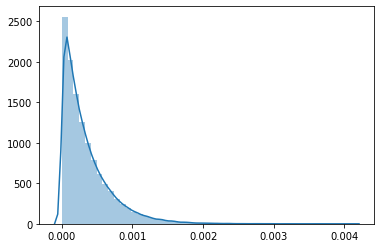

In [11]:
sbn.distplot(k)

In [12]:
obs = list()
for m in matrices:
    for o in m.flatten():
        obs.append(o)
        
        
k = np.array(obs)

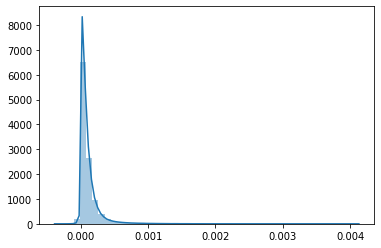

In [13]:
sbn.distplot(k)

In [14]:
# The distribution above looks similar to what we could expect given the distribution found empirically

In [15]:
# Saving the matrices
with open('..//data//simulated_covar_matrices.pickle', 'wb') as f:
    pickle.dump(matrices, f)

In [16]:
# Sampling means